## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [3]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


*Столбец date имеет тип данных object.*

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [5]:
data['date'] = pd.to_datetime(data['date'])
data.groupby('group')['date'].describe(datetime_is_numeric=True)

,count,mean,min,25%,50%,75%,max
group,,,,,,,
A,147202,2021-01-13 01:55:49.470795520,2021-01-02 00:00:00,2021-01-08 00:00:00,2021-01-13 00:00:00,2021-01-19 00:00:00,2021-01-24 00:00:00
B,147276,2021-01-13 01:23:47.034955008,2021-01-02 00:00:00,2021-01-08 00:00:00,2021-01-13 00:00:00,2021-01-19 00:00:00,2021-01-24 00:00:00


*Тест в обеих группах проводился со 2 по 24 января 2021 г.*

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [6]:
print('Количество посещений:\n', 
      data.groupby('group')['user_id'].count(), '\n')
print('Количество покупок:\n', 
      data.groupby('group')['purchase'].sum(), '\n')
print('Сумма покупок (млн):\n', 
      (data.groupby('group')['price'].sum() / 1_000_000).round(2))

Количество посещений:
 group
A    147202
B    147276
Name: user_id, dtype: int64 

Количество покупок:
 group
A    17723
B    17514
Name: purchase, dtype: int64 

Сумма покупок (млн):
 group
A    1436.26
B    1554.10
Name: price, dtype: float64


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [7]:
mask_A = data['group'] == 'A'
mask_B = data['group'] == 'B'
user_intersection = set(data[mask_A]['user_id']) \
    .intersection(set(data[mask_B]['user_id']))
print(len(user_intersection))

1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [8]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

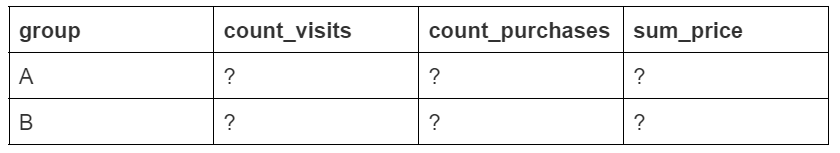
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [9]:
pivot_tab = updated_data.groupby('group') \
    .agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}) \
    .rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 
             'price': 'sum_price'})
display(pivot_tab)

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

*Тестовая и контрольная группы сопоставимы по количеству посещений (разница ~0.05%); выборки можно считать сбалансированными.*

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [10]:
pivot_tab['conversion'] \
    = (pivot_tab['count_purchases'] / pivot_tab['count_visits'] * 100).round(2)
pivot_tab['mean_check'] \
    = (pivot_tab['sum_price'] / pivot_tab['count_purchases']).round()
display(pivot_tab)

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.03,81076.0
B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

*Тестовый вариант (B) выглядит более эффективным по величине среднего чека и лишь незначительно менее эффективным по конверсии. Требуется проверка статистической значимости различий.*

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [11]:
pivot_tab = pd.pivot_table(updated_data, 
    values='purchase', index='group', columns='price', aggfunc='count')
pivot_tab.drop(0, axis=1, inplace=True)
display(pivot_tab)

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

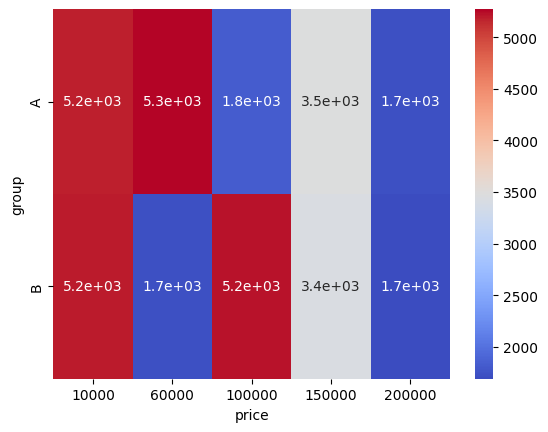

In [12]:
sns.heatmap(pivot_tab, annot=True, cmap='coolwarm');

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

*Заметны большие различия между группами в покупке туров за 60000 и 100000 р. Участники тестовой группы (B) покупают значительно больше туров за 100000, в то время как покупка туров за 60000 у них существенно снижена относительно контрольной группы A.*

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [13]:
daily = updated_data.groupby(['date', 'group']) \
    .agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}) \
    .rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 
             'price': 'sum_price'})
daily['conversion'] \
    = (daily['count_purchases'] / daily['count_visits'] * 100).round(2)
daily['mean_check'] \
    = (daily['sum_price'] / daily['count_purchases']).round()
display(daily.loc['2021-01-03'])

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,6596,748,62000000,11.34,82888.0
B,6619,754,65960000,11.39,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [14]:
daily['cumul_visits'] = daily.groupby('group')['count_visits'].cumsum()
daily['cumul_purchases'] = daily.groupby('group')['count_purchases'].cumsum()
daily['cumul_price'] = daily.groupby('group')['sum_price'].cumsum()

daily['cumul_conversion'] \
    = (daily['cumul_purchases'] / daily['cumul_visits'] * 100).round(2)
daily['cumul_mean_check'] \
    = (daily['cumul_price'] / daily['cumul_purchases']).round()

print('Кумулятивная конверсия в группе B 20 января 2021 г.: ',
      daily.loc['2021-01-20','B']['cumul_conversion'],'\n')
print('Кумулятивный средний чек в группе A 12 января 2021 г.: ',
      daily.loc['2021-01-12', 'A']['cumul_mean_check'])

Кумулятивная конверсия в группе B 20 января 2021 г.:  11.9 

Кумулятивный средний чек в группе A 12 января 2021 г.:  81492.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

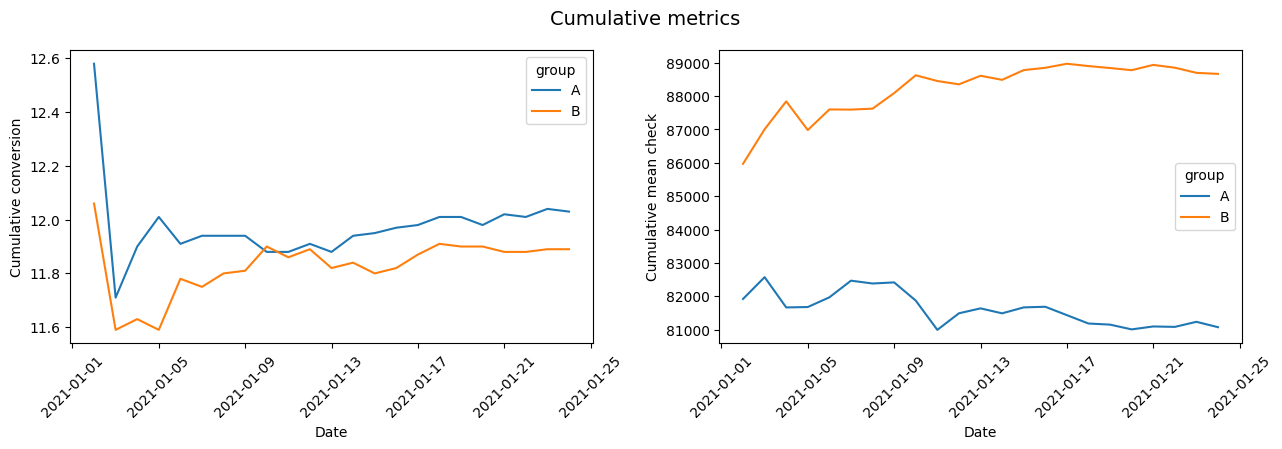

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
sns.lineplot(data=daily.reset_index(), 
             x='date', y='cumul_conversion', hue='group', ax=ax[0])
sns.lineplot(data=daily.reset_index(), 
             x='date', y='cumul_mean_check', hue='group', ax=ax[1])
fig.subplots_adjust(top=.85)
fig.suptitle('Cumulative metrics', fontsize=14)
plt.tight_layout()
ax[0].xaxis.set_tick_params(rotation=45)
ax[1].xaxis.set_tick_params(rotation=45)
ax[0].set(xlabel='Date', ylabel='Cumulative conversion')
ax[1].set(xlabel='Date', ylabel='Cumulative mean check');

*Кумулятивные метрики стабилизировались, A/B-тестирование можно считать завершенным. Кумулятивная конверсия в тестовой группе (B) несколько меньше конверсии в контрольной группе (A). Кумулятивный средний чек тестовой группы выше с первого дня и на всем протяжении тестирования*

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [16]:
# Считаем показатели пропорциq по группам: число успехов (success), число попыток (nobs)
proportion_tab = updated_data.groupby('group')['purchase'].agg(['sum', 'count']) \
    .rename(columns={'sum': 'success', 'count': 'nobs'})
display(proportion_tab)

_, p = proportions_ztest(
    count=proportion_tab['success'],
    nobs=proportion_tab['nobs'],           
    alternative='larger'  # A > B
)
print(f'p-value = {p:.3f}')

,success,nobs
group,,
A,17487,145307
B,17290,145381


p-value = 0.120


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

*p-value превышает заданный уровень значимости $\alpha$ = 0.05, следовательно нулевую гипотезу отвергнуть нельзя, а разница конверсий статистически незначима*

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [17]:
def proportion_conf_interval(n, x_p, gamma=0.95):
    """Calculating confidence interval for a sample proportion

    Args:
        n (int): sample size
        x_p (float, 0 < x_p < 1): sample proportion
        gamma (float, optional): confidence level. Defaults to 0.95.

    Returns:
        tuple: left and right boundaries of the confidence interval in percent
    """
    from scipy.stats import norm
     
    alpha = 1 - gamma                        # significance level
    z_crit = -norm.ppf(alpha/2)              # z critical
    eps = z_crit * (x_p*(1-x_p)/n)**0.5      # +-
    lower_bound = round((x_p-eps) * 100, 2)  # left (lower) boundary
    upper_bound = round((x_p+eps) * 100, 2)  # right (upper) boundary
    
    return (lower_bound, upper_bound)


def diff_proportion_conf_interval(n, x_p, gamma=0.95):
    """ Calculating confidence interval for a difference in proportions
        of two samples

    Args:
        n (list of integers: sizes of the two samples as [size_A, size_B]
        x_p (list of floats): sample proportions
        gamma (float, optional): confidence level. Defaults to 0.95.
        
    Returns:
        tuple: left and right boundaries of the confidence interval in percent
    """
    from scipy.stats import norm

    alpha = 1 - gamma
    diff = x_p[1] - x_p[0]
    z_crit = -norm.ppf(alpha/2)               # z critical
    eps = z_crit * (x_p[0]*(1-x_p[0])/n[0] + x_p[1]*(1-x_p[1])/n[1])**0.5
    lower_bound = round((diff-eps) * 100, 2)  # left (lower) boundary
    upper_bound = round((diff+eps) * 100, 2)  # right (upper) boundary
    
    return (lower_bound, upper_bound)


# Доверительный интервал конверсии группы A:
n_A = proportion_tab.loc['A']['nobs']
xp_A = proportion_tab.loc['A']['success'] / proportion_tab.loc['A']['nobs']
conf_interval = proportion_conf_interval(n_A, xp_A)
print(f'Группа A, доверительный интервал: {conf_interval[0]}%, {conf_interval[1]}%')

# Доверительный интервал конверсии группы B:
n_B = proportion_tab.loc['B']['nobs']
xp_B = proportion_tab.loc['B']['success'] / proportion_tab.loc['B']['nobs']
conf_interval = proportion_conf_interval(n_B, xp_B)
print(f'Группа B, доверительный интервал: {conf_interval[0]}%, {conf_interval[1]}%')

# Доверительный интервал разницы конверсий:
n = [n_A, n_B]
xp = [xp_A, xp_B]
conf_interval = diff_proportion_conf_interval(n, xp, gamma=0.95)
print(f'Разница пропорций, доверительный интервал: {conf_interval[0]}%, {conf_interval[1]}%')

Группа A, доверительный интервал: 11.87%, 12.2%
Группа B, доверительный интервал: 11.73%, 12.06%
Разница пропорций, доверительный интервал: -0.38%, 0.09%


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

*Доверительные интервалы для конверсий в тестовой и контрольной группах значительно перекрываются. Доверительный интервал для разницы пропорций включает в себя ноль (левая граница - в области отрицательных значений, правая - в области положительных), это показывает, что различие конверсий статистически незначимо.*

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [18]:
daily = daily.reset_index()  # Индексы в колонки
# Выборки средних чеков в группах:
mean_check_A = daily[daily['group'] == 'A']['mean_check']
mean_check_B = daily[daily['group'] == 'B']['mean_check']

_, p = shapiro(mean_check_A)
print(f'Группа A, p-value = {p:.3f}')

_, p = shapiro(mean_check_B)
print(f'Группа B, p-value = {p:.3f}')

Группа A, p-value = 0.253
Группа B, p-value = 0.094


* *Для проверки распределений на нормальность применим тест Shapiro-Wilk. Устанавливаем стандартный уровень значимости $\alpha$ = 0.05.*
* *Нулевая гипотеза - распределение нормальное, альтернативная гипотеза - распределение отлично от нормального.*
* *В обеих группах p-value превышает установленный уровень значимости, следовательно нулевая гипотеза не отвергается, распределения можно считать нормальными.*

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [19]:
_, p = ttest_ind(mean_check_A, mean_check_B, alternative='less')
print(f'p-value = {p:.3e}')

p-value = 1.128e-12


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

*Применяем односторонний t-критерий для независимых выборок. Значение p-value меньше установленного уровня значимости, следовательно нулевая гипотеза о равенстве средних чеков отвергается, и принимается альтернативная - средний чек в группе A меньше, чем в группе B.*

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [20]:
def mean_conf_interval(n, x_mean, sd, gamma=0.95):    
    """Calculating confidence interval for a mean value
       using Student's t-distribution

    Args:
        n (int): sample size
        x_mean (float): mean value
        sd (float): standard deviation
        gamma (float, optional): confidence level. Defaults to 0.95.
        
    Returns:
        tuple: left and right boundaries of the confidence interval
    """
    from scipy.stats import t
            
    alpha = 1 - gamma              # significance level
    t_crit = -t.ppf(alpha/2, n-1)  # t critical
    eps = t_crit * sd / n**0.5     # +-
    lower_bound = x_mean - eps     # left (lower) boundary
    upper_bound = x_mean + eps     # right (upper) boundary
        
    return (lower_bound, upper_bound)


n = len(mean_check_A)         # размер выборки A      
x_mean = mean_check_A.mean()  # средний чек, усредненный по выборке A
sd = mean_check_A.std()       # выборочная дисперсия
conf_interval = mean_conf_interval(n, x_mean, sd)
print('Выборка A, доверительный интервал (95%):', 
      '%.0f'%conf_interval[0], '%.0f'%conf_interval[1])

n = len(mean_check_B)         # размер выборки B     
x_mean = mean_check_B.mean()  # средний чек, усредненный по выборке B
sd = mean_check_B.std()       # выборочная дисперсия
conf_interval = mean_conf_interval(n, x_mean, sd)
print('Выборка B, доверительный интервал (95%):', 
      '%.0f'%conf_interval[0], '%.0f'%conf_interval[1])

Выборка A, доверительный интервал (95%): 79630 82308
Выборка B, доверительный интервал (95%): 87626 89526


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

*Доверительные интервалы для групп A и B не пересекаются, различия в среднем чеке статистически значимы.*

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

*В тестовой группе (B) средний чек выше, чем в контрольной (А), при этом различия в конверсиях нет (различие статистически незначимо). Таким образом, применение варианта дизайна B позволит увеличить прибыль. Анализ количества продаж в зависимости от стоимости тура показывает, что в тестовой группе B увеличение среднего чека происходит за счет того, что при выборе между турами за 60 т.р. и 100 т.р. клиенты выбирают более дорогостоящий тур чаще, чем в контрольной группе A.*